In [9]:

from highway_env.envs import HighwayEnv
from gymnasium.wrappers import TimeLimit

config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["x", "y", "vx", "vy"],
        "normalize": True,
    },
    "policy_frequency": 15,
    "duration": 40
}

In [10]:

import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import gymnasium as gym
import highway_env
import heapq

# Discretization bins
POSITION_BINS = np.linspace(0, 1, 6)
SPEED_BINS = np.linspace(0, 1, 5)
LANE_BINS = np.linspace(0, 1, 3)

def discretize(observation):
    ego = observation[0]
    x, y, vx, vy = ego
    x_bin = np.digitize(x, POSITION_BINS)
    vx_bin = np.digitize(vx, SPEED_BINS)
    lane_bin = np.digitize(y, LANE_BINS)
    return (x_bin, vx_bin, lane_bin)


In [11]:


base_env = HighwayEnv()
base_env.configure(config)
env = TimeLimit(base_env, max_episode_steps=40)
env.reset()


episodes = 500
alpha = 0.1
gamma = 0.99
epsilon = 0.1
q_learning_rewards = []
Q = defaultdict(lambda: np.zeros(env.action_space.n))

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)
    done = False
    total_reward = 0

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize(next_obs)
        done = terminated or truncated
        total_reward += reward

        best_next_action = np.argmax(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
        state = next_state

    q_learning_rewards.append(total_reward)


In [12]:

Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
double_q_learning_rewards = []

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)
    done = False
    total_reward = 0

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q1[state] + Q2[state])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize(next_obs)
        done = terminated or truncated
        total_reward += reward

        if random.random() < 0.5:
            a_star = np.argmax(Q1[next_state])
            Q1[state][action] += alpha * (reward + gamma * Q2[next_state][a_star] - Q1[state][action])
        else:
            a_star = np.argmax(Q2[next_state])
            Q2[state][action] += alpha * (reward + gamma * Q1[next_state][a_star] - Q2[state][action])

        state = next_state

    double_q_learning_rewards.append(total_reward)


In [13]:

Q = defaultdict(lambda: np.zeros(env.action_space.n))
model = {}
priority_queue = []
theta = 0.01
planning_steps = 10
prioritized_sweeping_rewards = []

def update_priority(s, a, r, s_prime):
    priority = abs(r + gamma * np.max(Q[s_prime]) - Q[s][a])
    if priority > theta:
        heapq.heappush(priority_queue, (-priority, s, a))

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)
    done = False
    total_reward = 0

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize(next_obs)
        done = terminated or truncated
        total_reward += reward

        model[(state, action)] = (reward, next_state)
        update_priority(state, action, reward, next_state)

        for _ in range(planning_steps):
            if not priority_queue:
                break
            _, s, a = heapq.heappop(priority_queue)
            r, s_prime = model[(s, a)]
            Q[s][a] += alpha * (r + gamma * np.max(Q[s_prime]) - Q[s][a])

            for (sprev, aprev), (rprev, s_next) in model.items():
                if s_next == s:
                    update_priority(sprev, aprev, rprev, s)
        state = next_state

    prioritized_sweeping_rewards.append(total_reward)


Q-learning: Avg=32.86, Std=2.88, Convergence Episode=N/A
Double Q-learning: Avg=31.74, Std=2.40, Convergence Episode=N/A
Prioritized Sweeping: Avg=33.77, Std=3.40, Convergence Episode=N/A


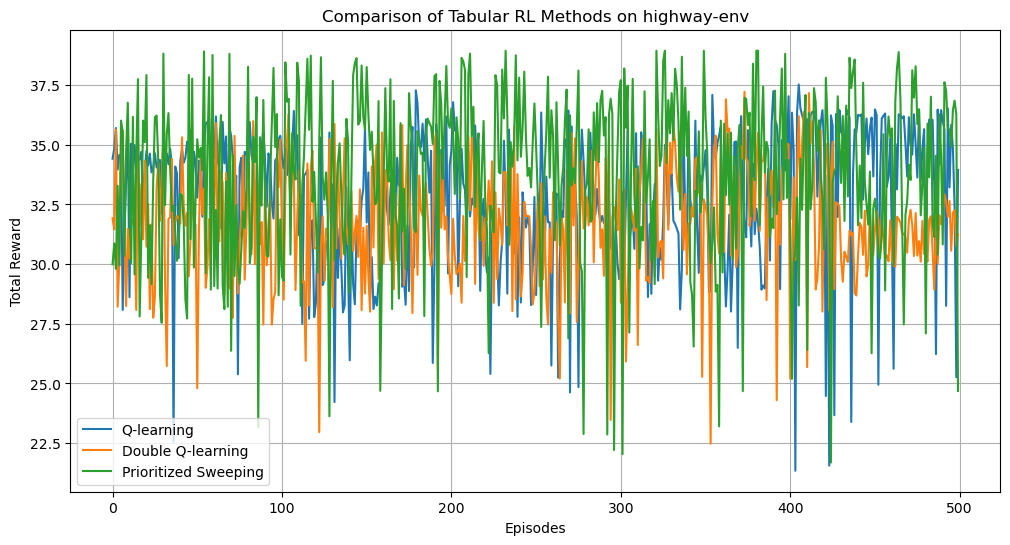

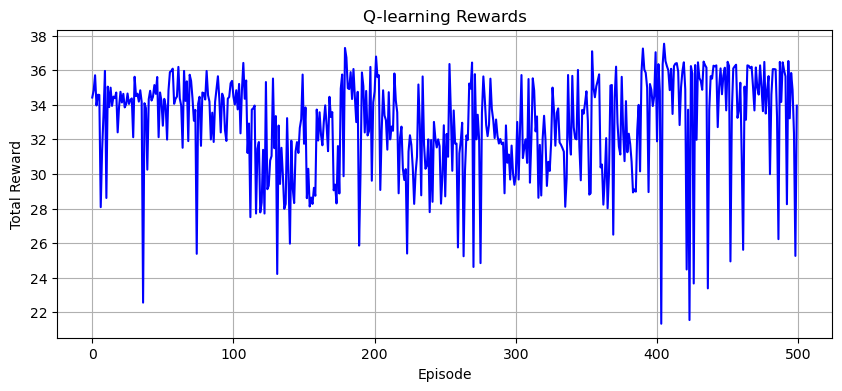

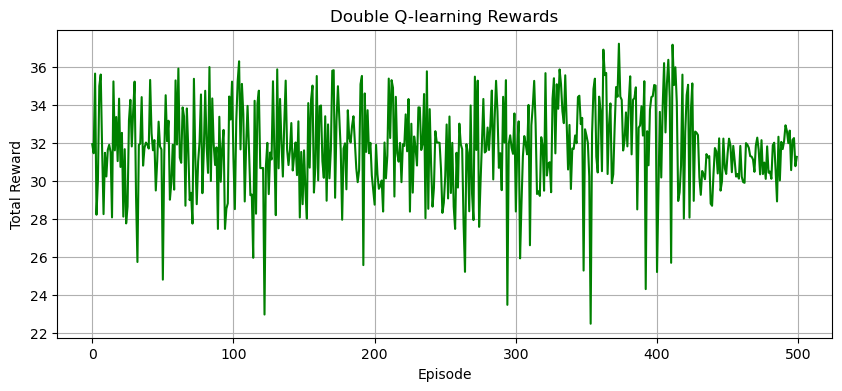

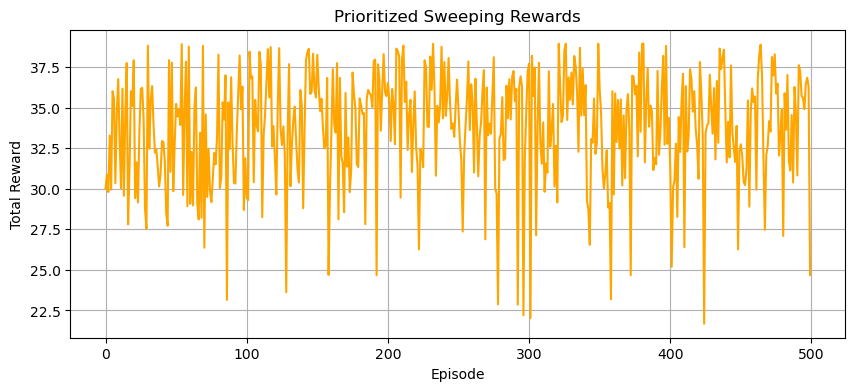

In [16]:

# Compute metrics
def summarize_rewards(rewards, label):
    avg = np.mean(rewards)
    std = np.std(rewards)
    convergence_ep = next((i for i in range(len(rewards) - 10) if np.mean(rewards[i:i+10]) > 90), "N/A")
    print(f"{label}: Avg={avg:.2f}, Std={std:.2f}, Convergence Episode={convergence_ep}")

summarize_rewards(q_learning_rewards, "Q-learning")
summarize_rewards(double_q_learning_rewards, "Double Q-learning")
summarize_rewards(prioritized_sweeping_rewards, "Prioritized Sweeping")

# Comparison Plot
episodes_range = list(range(episodes))
plt.figure(figsize=(12, 6))
plt.plot(episodes_range, q_learning_rewards, label="Q-learning")
plt.plot(episodes_range, double_q_learning_rewards, label="Double Q-learning")
plt.plot(episodes_range, prioritized_sweeping_rewards, label="Prioritized Sweeping")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Comparison of Tabular RL Methods on highway-env")
plt.legend()
plt.grid(True)
plt.savefig("Comparison-of-Tabular-RL-Methods.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Individual plots
plt.figure(figsize=(10, 4))
plt.plot(q_learning_rewards, color="blue")
plt.title("Q-learning Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.savefig("q-learning-rewards.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(double_q_learning_rewards, color="green")
plt.title("Double Q-learning Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.savefig("double-q-learning-rewards.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(prioritized_sweeping_rewards, color="orange")
plt.title("Prioritized Sweeping Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.savefig("prioritized-sweeping-rewards.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [17]:
import numpy as np

# Number of episodes to average over at the end
last_n = 100

print(f"{'Method':<25} | {'Avg Reward':<10} | {'Std Dev':<10} | {'Final Reward':<10}")
print("-" * 65)

results = {
    "Q-learning": {"rewards": q_learning_rewards},
    "Double Q-learning": {"rewards": double_q_learning_rewards},
    "Prioritized Sweeping": {"rewards": prioritized_sweeping_rewards}
}


for method, data in results.items():
    rewards = np.array(data['rewards'])
    if len(rewards) < last_n:
        avg_reward = rewards.mean()
        std_reward = rewards.std()
        final_reward = rewards[-1]
    else:
        avg_reward = rewards[-last_n:].mean()
        std_reward = rewards[-last_n:].std()
        final_reward = rewards[-1]
    
    print(f"{method:<25} | {avg_reward:<10.2f} | {std_reward:<10.2f} | {final_reward:<10.2f}")


Method                    | Avg Reward | Std Dev    | Final Reward
-----------------------------------------------------------------
Q-learning                | 34.10      | 3.54       | 33.95     
Double Q-learning         | 31.46      | 2.04       | 31.26     
Prioritized Sweeping      | 33.73      | 3.36       | 24.69     
